# Finely-Tuned BERT Model - Automatic Grading (Dataset 1)

Omar Ebrahim - 202000443

1. Importing the libraries

In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time

from peft import LoraConfig, TaskType, get_peft_model

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr 
from sklearn.metrics import mean_absolute_error

c:\Users\Omar\anaconda3\envs\CS4120\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Importing the dataset and defining the BERTTokenizer

In [2]:
df = pd.read_csv("C:/Users/Omar/OneDrive/Desktop/totalmerged.csv")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

3. Creating a CustomDataset which replaces the sample and student answers with their tokenized versions, and adds from the original dataset the original question and scores.

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        question = str(self.data.loc[index, 'Question'])
        correct_code = str(self.data.loc[index, 'Correct_Code'])
        code_with_error = str(self.data.loc[index, 'Code_with_Error'])
        total_marks = self.data.loc[index, 'Total_Marks']
        
        inputs = self.tokenizer(correct_code,
                                add_special_tokens=True, 
                                max_length=self.max_length, 
                                padding='max_length', 
                                truncation=True, 
                                return_tensors='pt')
        
        inputs2 = self.tokenizer(code_with_error,
                                 add_special_tokens=True, 
                                 max_length=self.max_length, 
                                 padding='max_length', 
                                 truncation=True, 
                                 return_tensors='pt')
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'input_ids2': inputs2['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'attention_mask2': inputs2['attention_mask'].flatten(),
            'total_marks': torch.tensor(total_marks, dtype=torch.float)
        }

dataset = CustomDataset(df, tokenizer)

4. Calling the original BERTModel

In [4]:
model = BertModel.from_pretrained('bert-base-uncased')

5. Creating the LoRA configuration with their default values, and then adding it to the BERTModel for the purpose of reducing trainable parameters

In [5]:
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # Task type for which the model will undergo fine-tuning
    r=1,  # Dimensions of A and B
    lora_alpha=1,  # Scaling factor determining the relative significance of weights in A and B
    lora_dropout=0.1  # Dropout probability for LoRA
)

In [6]:
model = get_peft_model(model, lora_config)
model.eval()

PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=1, bias=False)
                  )
                 

6. Generating the word embeddings for sample answers and the student answers. The training time in seconds is recorded after embeddings are generated.

In [7]:
start_time = time.time()
BMwordEmbeddings1 = []
BMwordEmbeddings2 = []

with torch.no_grad():
    for example in DataLoader(dataset, batch_size=1):
        input_ids = example['input_ids']
        attention_mask = example['attention_mask']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        BMwordEmbeddings1.append(embeddings.squeeze().detach().numpy())

    for example in DataLoader(dataset, batch_size=1):
        input_ids2 = example['input_ids2']
        attention_mask2 = example['attention_mask2']

        outputs = model(input_ids=input_ids2, attention_mask=attention_mask2)
        embeddings = outputs.last_hidden_state
        BMwordEmbeddings2.append(embeddings.squeeze().detach().numpy())

BMwordEmbeddings1 = np.array(BMwordEmbeddings1)
BMwordEmbeddings2 = np.array(BMwordEmbeddings2)

np.save('BMwordEmbeddings1.npy', BMwordEmbeddings1)
np.save('BMwordEmbeddings2.npy', BMwordEmbeddings2)
end_time = time.time()
runTime = end_time - start_time
print(f"Time: {runTime} seconds")

Time: 534.5741560459137 seconds


7. Evaluation:
   1. Generating the new scores by doing cosine similarity between embedded student answers and embedded model answers (rescaled between 1-10)
   2. After getting both scores, we compare them using using MAE and Pearson correlation
   3. MAPE was used additionally to see the % difference between both grades per row

In [8]:
MAE = []
MAPE = []
Pearson = []
predicted_scores = []

BMwordEmbeddings1 = np.load('BMwordEmbeddings1.npy', allow_pickle=True)
BMwordEmbeddings2 = np.load('BMwordEmbeddings2.npy', allow_pickle=True)

print("Original Score | Predicted Score | MAPE (%)")
print("--------------------------------------------")
for i in range(len(BMwordEmbeddings1)):
    BMWordEmbeddings1_i = BMwordEmbeddings1[i].reshape(1, -1)
    BMWordEmbeddings2_i = BMwordEmbeddings2[i].reshape(1, -1)

    similarity = cosine_similarity(BMWordEmbeddings1_i, BMWordEmbeddings2_i)[0][0]

    scaled_similarity = similarity * 10
    
    predicted_score = max(min(scaled_similarity, 10), 0)
    original_score = df['Total_Marks'][i]

    mape = np.abs((predicted_score - original_score) / original_score) * 100

    print(f"{original_score:.2f}           | {predicted_score:.2f}            | {mape:.2f}")

    MAE.append(np.abs(predicted_score - original_score))
    MAPE.append(mape)
    Pearson.append((original_score, predicted_score))
    predicted_scores.append(predicted_score) 

MAE = np.mean(MAE)
MAPE = np.mean(MAPE)
pearson_corr = np.array(Pearson)
corr_coefficient, _ = pearsonr(pearson_corr[:,0], pearson_corr[:,1])

print(f"\nMean Absolute Error: {MAE:.2f}")
print(f"Pearson Correlation: {corr_coefficient:.2f}")

Original Score | Predicted Score | MAPE (%)
--------------------------------------------
7.00           | 5.70            | 18.50
8.00           | 5.86            | 26.76
5.00           | 7.82            | 56.45
7.00           | 8.27            | 18.11
5.00           | 6.34            | 26.84
8.00           | 5.99            | 25.14
4.00           | 4.45            | 11.30
7.00           | 5.41            | 22.71
5.00           | 5.01            | 0.19
6.00           | 8.23            | 37.15
3.00           | 4.77            | 59.11
8.00           | 4.49            | 43.89
5.00           | 7.66            | 53.30
5.00           | 9.52            | 90.41
6.00           | 4.54            | 24.30
6.00           | 4.75            | 20.85
3.00           | 4.70            | 56.80
7.00           | 4.67            | 33.24
4.00           | 4.53            | 13.27
5.00           | 4.56            | 8.86
6.00           | 4.62            | 23.08
5.00           | 4.56            | 8.75
1.00        

C:\Users\Omar\AppData\Local\Temp\ipykernel_720\1622881885.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100


9.00           | 4.63            | 48.55
7.00           | 5.65            | 19.27
5.00           | 3.41            | 31.74
10.00           | 4.53            | 54.74
9.00           | 8.93            | 0.79
4.00           | 6.89            | 72.19
6.00           | 4.14            | 30.96
6.00           | 8.19            | 36.57
9.00           | 6.75            | 24.99
6.00           | 8.23            | 37.17
5.00           | 4.15            | 16.92
8.00           | 10.00            | 25.00
8.00           | 9.13            | 14.17
8.00           | 10.00            | 25.00
9.00           | 5.71            | 36.58
6.00           | 3.54            | 41.00
7.00           | 5.87            | 16.08
6.00           | 3.59            | 40.10
7.00           | 8.92            | 27.44
6.00           | 3.58            | 40.33
9.00           | 9.90            | 10.02
6.00           | 9.96            | 66.00
6.00           | 7.75            | 29.21
7.00           | 4.77            | 31.85
10.00         

C:\Users\Omar\AppData\Local\Temp\ipykernel_720\1622881885.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_720\1622881885.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100


7.00           | 8.85            | 26.47
8.00           | 5.91            | 26.15
8.00           | 7.95            | 0.64
7.00           | 5.95            | 14.99
7.00           | 5.92            | 15.46
7.00           | 4.56            | 34.85
7.00           | 4.44            | 36.58
7.00           | 9.91            | 41.57
7.00           | 10.00            | 42.86
7.00           | 9.94            | 42.03
7.00           | 9.58            | 36.86
7.00           | 8.24            | 17.77
5.00           | 9.89            | 97.76
7.00           | 9.95            | 42.20
7.00           | 9.15            | 30.67
7.00           | 9.93            | 41.86
8.00           | 5.97            | 25.37
7.00           | 4.91            | 29.81
8.00           | 5.76            | 27.96
6.00           | 4.93            | 17.87
7.00           | 8.15            | 16.45
6.00           | 5.76            | 3.95
7.00           | 5.83            | 16.70
7.00           | 6.15            | 12.15
7.00           | 

C:\Users\Omar\AppData\Local\Temp\ipykernel_720\1622881885.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_720\1622881885.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_720\1622881885.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100


10.00           | 3.85            | 61.51
10.00           | 4.02            | 59.79
10.00           | 10.00            | 0.00
8.00           | 8.41            | 5.09
8.00           | 9.97            | 24.63
7.00           | 5.53            | 20.94
8.00           | 9.97            | 24.63
8.00           | 9.95            | 24.37
8.00           | 7.08            | 11.53
8.00           | 5.56            | 30.51
8.00           | 10.00            | 25.00
8.00           | 9.87            | 23.37
8.00           | 10.00            | 25.00
9.00           | 8.52            | 5.31
8.00           | 7.79            | 2.64
8.00           | 10.00            | 25.00
8.00           | 9.27            | 15.86
8.00           | 9.91            | 23.94
8.00           | 9.85            | 23.12
8.00           | 9.91            | 23.94
8.00           | 6.23            | 22.10
9.00           | 9.38            | 4.17
8.00           | 10.00            | 25.00
8.00           | 7.09            | 11.38
8.00         

8. Visualizing the grading distributions between the BERT scores and the original scores.

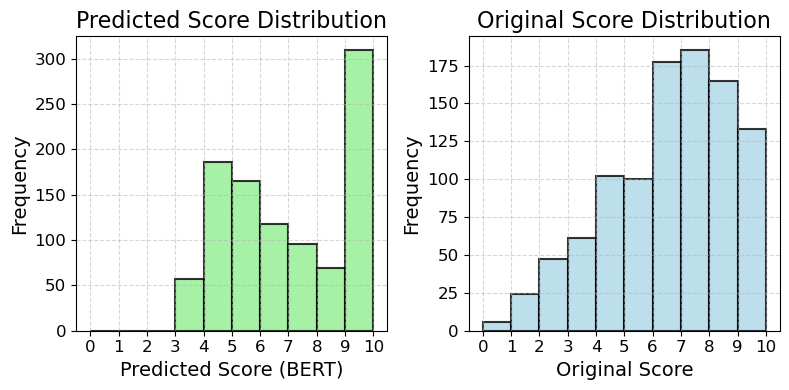

In [9]:
import matplotlib.pyplot as plt

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(predicted_scores, bins=bins, color='lightgreen', edgecolor='black', alpha=0.8, linewidth=1.5)
plt.xlabel('Predicted Score (BERT)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Predicted Score Distribution', fontsize=16)
plt.xticks(bins, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.hist(df['Total_Marks'], bins=bins, color='lightblue', edgecolor='black', alpha=0.8, linewidth=1.5)
plt.xlabel('Original Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Original Score Distribution', fontsize=16)
plt.xticks(bins, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

9. Applying the same concept of semantic similarity, but instead replacing it with Euclidean Distance.
Given euclidean distance is unbounded, I first collected the Euclidean results after performing similarity, defined the maximum and minimum values, then rescaled the results between 0-10

In [10]:
from sklearn.metrics.pairwise import euclidean_distances

BMwordEmbeddings1 = np.load('BMwordEmbeddings1.npy', allow_pickle=True)
BMwordEmbeddings2 = np.load('BMwordEmbeddings2.npy', allow_pickle=True)

distances = []

for i in range(len(BMwordEmbeddings1)):
    BMwordEmbeddings1_i = BMwordEmbeddings1[i].reshape(1, -1)
    BMwordEmbeddings2_i = BMwordEmbeddings2[i].reshape(1, -1)
    distance = euclidean_distances(BMwordEmbeddings1_i, BMwordEmbeddings2_i)[0][0]
    distances.append(distance)

distances = np.array(distances)

min_dist = distances.min()
max_dist = distances.max()

normalized_distances = (distances - min_dist) / (max_dist - min_dist)
scaled_distances = normalized_distances * 10

MAE = []
MAPE = []
Pearson = []

print("Original Score | Predicted Score | MAPE (%)")
print("--------------------------------------------")

for i in range(len(BMwordEmbeddings1)):
    original_score = df['Total_Marks'][i]
    predicted_score = scaled_distances[i]

    mape = np.abs((predicted_score - original_score) / original_score) * 100

    print(f"{original_score:.2f}           | {predicted_score:.2f}            | {mape:.2f}")

    MAE.append(np.abs(predicted_score - original_score))
    MAPE.append(mape)
    Pearson.append((original_score, predicted_score))

MAE = np.mean(MAE)
MAPE = np.mean(MAPE)
pearson_corr = np.array(Pearson)
corr_coefficient, _ = pearsonr(pearson_corr[:,0], pearson_corr[:,1])

print(f"\nMean Absolute Error: {MAE:.2f}")
print(f"Pearson Correlation: {corr_coefficient:.2f}")

Original Score | Predicted Score | MAPE (%)
--------------------------------------------
7.00           | 7.80            | 11.43
8.00           | 7.61            | 4.90
5.00           | 5.56            | 11.20
7.00           | 4.95            | 29.28
5.00           | 7.19            | 43.77
8.00           | 7.53            | 5.89
4.00           | 8.88            | 121.90
7.00           | 8.04            | 14.80
5.00           | 8.37            | 67.47
6.00           | 5.00            | 16.59
3.00           | 8.63            | 187.74
8.00           | 8.85            | 10.64
5.00           | 5.73            | 14.54
5.00           | 2.61            | 47.82
6.00           | 8.79            | 46.53
6.00           | 8.64            | 44.03
3.00           | 8.68            | 189.23
7.00           | 8.71            | 24.41
4.00           | 8.80            | 120.04
5.00           | 8.80            | 75.98
6.00           | 8.70            | 45.08
5.00           | 8.78            | 75.69
1.00   

C:\Users\Omar\AppData\Local\Temp\ipykernel_720\107753709.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100


10. Applying the same concept of semantic similarity, but instead replacing it with Manhattan Distance.
Given euclidean distance is unbounded, I first collected the Manhattan results after performing similarity, defined the maximum and minimum values, then rescaled the results between 0-10

In [11]:
from sklearn.metrics.pairwise import manhattan_distances

BMwordEmbeddings1 = np.load('BMwordEmbeddings1.npy', allow_pickle=True)
BMwordEmbeddings2 = np.load('BMwordEmbeddings2.npy', allow_pickle=True)

distances = []

for i in range(len(BMwordEmbeddings1)):
    BMwordEmbeddings1_i = BMwordEmbeddings1[i].reshape(1, -1)
    BMwordEmbeddings2_i = BMwordEmbeddings2[i].reshape(1, -1)
    distance = manhattan_distances(BMwordEmbeddings1_i, BMwordEmbeddings2_i)[0][0]
    distances.append(distance)

distances = np.array(distances)

min_dist = distances.min()
max_dist = distances.max()

normalized_distances = (distances - min_dist) / (max_dist - min_dist)
scaled_distances = normalized_distances * 10

MAE = []
MAPE = []
Pearson = []

print("Original Score | Predicted Score | MAPE (%)")
print("--------------------------------------------")

for i in range(len(BMwordEmbeddings1)):
    original_score = df['Total_Marks'][i]
    predicted_score = scaled_distances[i]

    mape = np.abs((predicted_score - original_score) / original_score) * 100

    print(f"{original_score:.2f}           | {predicted_score:.2f}            | {mape:.2f}")

    MAE.append(np.abs(predicted_score - original_score))
    MAPE.append(mape)
    Pearson.append((original_score, predicted_score))

MAE = np.mean(MAE)
MAPE = np.mean(MAPE)
pearson_corr = np.array(Pearson)
corr_coefficient, _ = pearsonr(pearson_corr[:,0], pearson_corr[:,1])

print(f"\nMean Absolute Error: {MAE:.2f}")
print(f"Pearson Correlation: {corr_coefficient:.2f}")

Original Score | Predicted Score | MAPE (%)
--------------------------------------------
7.00           | 7.03            | 0.42
8.00           | 6.68            | 16.44
5.00           | 3.81            | 23.72
7.00           | 3.37            | 51.84
5.00           | 5.84            | 16.89
8.00           | 6.54            | 18.22
4.00           | 8.48            | 111.95
7.00           | 7.33            | 4.73
5.00           | 7.67            | 53.45
6.00           | 3.45            | 42.43
3.00           | 8.18            | 172.53
8.00           | 8.46            | 5.76
5.00           | 4.19            | 16.21
5.00           | 1.30            | 74.01
6.00           | 8.43            | 40.45
6.00           | 8.20            | 36.66
3.00           | 8.24            | 174.67
7.00           | 8.27            | 18.14
4.00           | 8.37            | 109.29
5.00           | 8.39            | 67.70
6.00           | 8.31            | 38.51
5.00           | 8.41            | 68.11
1.00    

C:\Users\Omar\AppData\Local\Temp\ipykernel_720\4204946055.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
